### ML-model

In [101]:
import pandas as pd
import numpy as np
import qml

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies')
import qml_interface as qmi
import utils_qm as uqm
import hyperparameter_optimization as hp

def split_data_by_index(data, subset1_indices):
    subset1 = data[subset1_indices]
    
    indices = np.arange(len(data))
    subset2_indices = indices[[i for i in range(len(data)) if i not in subset1_indices]]
    subset2 = data[subset2_indices]
    
    return(subset1, subset2)

# read energies, smiles
# data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
# row2 = data.loc[(data['Z1'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] >= 6) & (data['Z2'] <= 9)]
# smiles = list(row2['smiles'])
# energies = -630*np.array(row2['bfe']) # BDE in kcal/mol

data_W4_17 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/W4-17.csv')
smiles = data_W4_17['smiles']
energies = -np.array(data_W4_17['bfe']) # BDE in kcal/mol

# read structures, make representations
reps = []
for s in smiles:
    p = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/{s}_opt.xyz'
    comp = qml.Compound(p)
    #comp.generate_coulomb_matrix(size=8, sorting="row-norm")
    
    comp.generate_bob(size=8, asize={"O":2, "C":2, "N":2, "F":2,"H":6})
    
    reps.append(comp.representation)

reps = np.array(reps)

In [102]:
reps[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 36.8581052 , 36.8581052 , 23.70322967,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  5.49108811,  5.49108717,
        5.49108685,  5.49108541,  5.49108475,  5.49108224,  2.76401913,
        2.76401776,  2.76401707,  2.76401421,  2.76401334,  2.76401319,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [103]:
# from ase.visualize import view
# import ase.io as aio
# view(aio.read(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/CN_opt.xyz'))

In [110]:
test_predictions = []

for test_ind in range(len(energies)):
    # split into training and test
    rep_test, rep_tr = split_data_by_index(reps, [test_ind])
    label_test, labels_tr =  split_data_by_index(energies, [test_ind])

    all_errors = 0

    # for all possible splits of training data
    # split in training and validation
    
    # optimize hyperparameters
    sigma_grid = np.logspace(0, 3, 500) #np.logspace(2, 5, 100)
    #sigma_grid = np.logspace(2, 5, 100)
    lambda_val = 1e-7


    possible_splittings = len(labels_tr)
    for sigma_ind in range(possible_splittings):
        # split training data in coeff_set and validation set
        rep_sigma, rep_coeff = split_data_by_index(rep_tr, [sigma_ind])
        label_sigma, label_coeff = split_data_by_index(labels_tr, [sigma_ind])

        #lambda_grid = [1e-7]#[1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10]
        coeffs, errors = hp.sigma_grid_search(label_coeff, label_sigma, lambda_val, rep_coeff, rep_sigma, sigma_grid, "gaussian")
        
        #print(np.amin(errors))
        
        all_errors += errors

    ind_min = np.where(all_errors == np.amin(all_errors))[0][0]
    opt_sigma = sigma_grid[ind_min]
    
    print(opt_sigma)
    #print(np.amin(all_errors/9))

    coeffs = qmi.train_kernel(rep_tr, labels_tr, opt_sigma, lambda_val)



    prediction_test = qmi.predict_labels(rep_test, rep_tr, opt_sigma, coeffs)[0]

    test_predictions.append(prediction_test)

    
# predictions_cv = []
# for k in test_predictions.keys():
#     predictions_cv.append([test_predictions[k].mean(), test_predictions[k].std()])
# predictions_cv = np.array(predictions_cv)

88.69431656014709
92.45531098233575
109.16317341936147
100.46250617173413
89.93066723187623
88.69431656014709
88.69431656014709
89.93066723187623
86.2723729246145
88.69431656014709


12.119324057759789

In [66]:
import copy

In [67]:
gaussian_bob = copy.deepcopy(test_predictions)

In [72]:
laplacian_bob = copy.deepcopy(test_predictions)

In [77]:
laplacian_cm = copy.deepcopy(test_predictions)

In [82]:
gaussian_cm = copy.deepcopy(test_predictions)

In [68]:
from matplotlib import pyplot as plt

['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']

Text(0, 0.5, 'BDE (kcal/mol)')

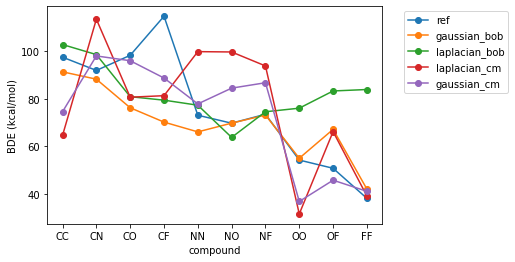

In [93]:
plt.plot(smiles.to_list(), energies, "-o", label = "ref")
plt.plot(gaussian_bob, '-o', label = 'gaussian_bob')
plt.plot(laplacian_bob, '-o', label = 'laplacian_bob')
plt.plot(laplacian_cm, '-o', label = 'laplacian_cm')
plt.plot(gaussian_cm, '-o', label = 'gaussian_cm')
plt.legend(bbox_to_anchor=(1.05,1))
plt.xlabel('compound')
plt.ylabel('BDE (kcal/mol)')


In [51]:
(np.abs(energies-np.array(test_predictions))).mean()

10.441272881324151

In [52]:
test_predictions

[91.26710581901247,
 88.18189047607495,
 76.21197231876965,
 70.20160155805426,
 66.10231461195826,
 69.76241876620196,
 73.15921638499874,
 55.055926236819516,
 67.15394704817251,
 42.12453793091599]

In [55]:
qml_dict = {'smiles':smiles.to_list(), 'BDE (kcal/mol)':test_predictions}
uqm.save_obj(qml_dict, '/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/bde_ml_W4-17_gaussian_bob')

In [ ]:
test_predictions = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for test_ind in range(len(energies)):
    # split into training and test
    rep_test, rep_tr = split_data_by_index(reps, [test_ind])
    label_test, labels_tr =  split_data_by_index(energies, [test_ind])

    opt_results = {'simga_ind':[], 'results':[]}

    # for all possible splits of training data
    # split in training and validation
    # optimize hyperparameters
    possible_splittings = len(labels_tr)
    for sigma_ind in range(possible_splittings):
        # split training data in coeff_set and validation set
        rep_sigma, rep_coeff = split_data_by_index(rep_tr, [sigma_ind])
        label_sigma, label_coeff = split_data_by_index(labels_tr, [sigma_ind])

        #lambda_grid = [1e-7]#[1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10]
        lambda_val = 1e-7
        sigma_grid = np.logspace(0, 4, 100)
        coeffs, errors = hp.sigma_grid_search(label_coeff, label_sigma, lambda_val, rep_coeff, rep_sigma, sigma_grid)
        
        opt_results['simga_ind'].append(sigma_ind)
        opt_results['results'].append({'coeffs':coeffs, 'errors':errors})
        
#         optimal_values['simga_ind'].append(sigma_ind)
#         optimal_values['coeffs_opt'].append(opt_coeffs)
#         optimal_values['lambda_opt'].append(opt_lambda)
#         optimal_values['sigma_opt'].append(opt_sigma)
#         optimal_values['sigma_error_opt'].append(opt_error)

    # for every split into training and validation
    # predict test point for optimal set of hyperparameters

    for i in range(len(labels_tr)):
        coeffs_opt = optimal_values['coeffs_opt'][i]
        sigma_opt = optimal_values['sigma_opt'][i]
        
        prediction_test = qmi.predict_labels(rep_test, rep_coeff, sigma_opt, coeffs_opt)[0]
        
        test_predictions[test_ind].append(prediction_test)
        
    test_predictions[test_ind] = np.array(test_predictions[test_ind])
    
predictions_cv = []
for k in test_predictions.keys():
    predictions_cv.append([test_predictions[k].mean(), test_predictions[k].std()])
predictions_cv = np.array(predictions_cv)

In [ ]:
optimal_values

In [ ]:
qml_df = pd.DataFrame({'smiles':smiles.to_list(), 'BDE (kcal/mol)':predictions_cv[:,0], 'BDE std':predictions_cv[:,1]})
#qml_df.to_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/bde_ml_W4-17_v2.csv',index=False)

qml_dict = {'smiles':smiles.to_list(), 'BDE (kcal/mol)':predictions_cv[:,0], 'BDE std':predictions_cv[:,1]}

#uqm.save_obj(qml_dict, '/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/bde_ml_W4-17_v2')

In [ ]:
from matplotlib import pyplot as plt
plt.plot(energies, energies, '--')
plt.plot(energies, predictions_cv[:,0], 'o')

In [ ]:
np.abs(predictions_cv[:,0]-energies).mean()